## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import gc
import feather
import panel as pn
pn.extension()
from panel import widgets
from panel.interact import interact, fixed
from bokeh.io import show, output_notebook
from bokeh.models import ColumnDataSource, HoverTool, CDSView, GroupFilter, Range1d, Label, Legend, LegendItem
from bokeh.plotting import figure
from bokeh.palettes import Category20c
from bokeh.transform import factor_cmap
import geopandas as gpd
from ipyleaflet import Map, GeoJSON
from prettytable import PrettyTable
from collections import Counter
import os
import subprocess
import folium


## Data

In [19]:
import sys
sys.path.append("dataset_v1")  # so Python can import the helper

from data_loader import load_frames, load_one

# Load all four dataframes
dfs = load_frames()
df_all_countries         = dfs["df_all_countries"]
df_active_countries      = dfs["df_active_countries"]
df_all_countries_tags    = dfs["df_all_countries_tags"]
df_active_countries_tags = dfs["df_active_countries_tags"]

# (Optional) quick sanity check
for name, df in dfs.items():
    print(name, df.shape, df.dtypes.head(), sep="\n", end="\n\n")


df_all_countries
(14640001, 10)
uid          int16
tid          int32
LEs          int16
artist    category
track     category
dtype: object

df_active_countries
(8466596, 10)
uid          int16
tid          int32
LEs          int16
artist    category
track     category
dtype: object

df_all_countries_tags
(11135197, 12)
uid          int16
tid          int32
LEs          int16
artist    category
track     category
dtype: object

df_active_countries_tags
(6356047, 12)
uid          int16
tid          int32
LEs          int16
artist    category
track     category
dtype: object



In [20]:
active_countries = sorted(df_active_countries["user_country"].unique().tolist())


# Plots

In [21]:
# for now i define a Fontsize for the Title and for the Label and for the X/Y Range
title_fontsize = 15
label_fontsize = 11
ticks_fontsize = 9

In [22]:
def prepare_counts(data: pd.DataFrame, gender_filter=None, age_group_filter=None):
    # Apply gender filter if specified
    if gender_filter and gender_filter != 'All':
        data = data[data['gender'] == gender_filter.lower()[0]]
    
    # Apply age group filter if specified
    if age_group_filter:
        min_age, max_age = age_group_filter
        data = data[(data['age'] >= min_age) & (data['age'] <= max_age)]

    res = dict()

    # Get unique user and artist countries
    u_countries = data['user_country'].unique()
    i_countries = data['artist_country'].unique()

    # Initialize the results dictionary
    for u_c in u_countries:
        res[u_c] = dict()
        for i_c in i_countries:
            res[u_c][i_c] = dict()
            res[u_c][i_c]['LEs'] = 0
            res[u_c][i_c]['unique'] = 0

    # Calculate listening events and unique interactions
    for u_c in tqdm(u_countries):
        u_c_data = data[data['user_country'] == u_c]

        total_unique_inters = len(u_c_data)
        total_LEs = u_c_data['LEs'].sum()

        LE_distr = u_c_data.groupby('artist_country')['LEs'].sum()
        cnt_distr = u_c_data.groupby('artist_country')['track'].count()

        for i_c in cnt_distr.index:
            if i_c in res[u_c]:
                res[u_c][i_c]['LEs'] += LE_distr[i_c]
                res[u_c][i_c]['unique'] += cnt_distr[i_c]
            else:
                res[u_c][i_c] = {'LEs': LE_distr[i_c], 'unique': cnt_distr[i_c]}

    return res

### ISMR Figure 1  - Listening Activity 

In [23]:
import pandas as pd
import numpy as np
import panel as pn
import matplotlib.pyplot as plt

# Ensure Panel widgets are available
pn.extension()

def prepare_counts_la(data: pd.DataFrame, targetCountries: list):
    # Initialize the result dictionary using defaultdict for automatic key creation
    from collections import defaultdict
    res = defaultdict(lambda: defaultdict(lambda: {'LEs': 0, 'unique': 0}))

    # Group by user_country and artist_country, and aggregate LEs and unique counts
    grouped = data.groupby(['user_country', 'artist_country']).agg(
        LEs=('LEs', 'sum'), 
        unique=('tid', 'nunique')
    ).reset_index()

    # Populate the result dictionary
    for _, row in grouped.iterrows():
        res[row['user_country']][row['artist_country']]['LEs'] += row['LEs']
        res[row['user_country']][row['artist_country']]['unique'] += row['unique']

    return res

# Unique over_genres sorted by frequency
over_genre_counts = df_all_countries_tags['over_genre'].value_counts()
unique_over_genres_sorted = ['All'] + over_genre_counts.index.tolist()

# Define the widgets for dataset selection, gender, age group, and genre filtering
dataset_filter = pn.widgets.RadioButtonGroup(name='Dataset', options=['All Countries', 'All Countries with Tags'], value='All Countries')
gender_filter = pn.widgets.Select(name='Gender', options=['All', 'Male', 'Female'], value='All')
age_group_filter = pn.widgets.IntRangeSlider(name='Age Group', start=0, end=80, value=(0, 80))
genre_filter = pn.widgets.Select(name='Genre', options=unique_over_genres_sorted, value='All')

# Define the widgets for user interaction
country_select = pn.widgets.CheckBoxGroup(name='Country', value=['US'], options=active_countries, inline=True, width=800)

# Function to update the dataset filter when a genre other than 'All' is selected
def update_dataset_filter(event):
    if genre_filter.value != 'All':
        dataset_filter.value = 'All Countries with Tags'

# Watch for changes in the genre_filter and call update_dataset_filter when it changes
genre_filter.param.watch(update_dataset_filter, 'value')

# Updated filter section with a better layout
la_filter_section = pn.Column(
    pn.pane.Markdown('### Data Selection and Filters', styles={"font-size": "20px"}),
    pn.Row(
        pn.Column(pn.pane.Markdown('**Select Dataset:**', styles={"font-size": "14px"}), dataset_filter),
        pn.Column(pn.pane.Markdown('**Select Genre:**', styles={"font-size": "14px"}), genre_filter),
    ),
    pn.Row(
        pn.Column(pn.pane.Markdown('**Select Gender:**', styles={"font-size": "14px"}), gender_filter),
        pn.Column(pn.pane.Markdown('**Select Age Group:**', styles={"font-size": "14px"}), age_group_filter),
    ),
    pn.Column(
        pn.pane.Markdown('**Select Artist Countries:**', styles={"font-size": "14px"}), 
        country_select
    ),
    sizing_mode='stretch_width'
)

def listening_activity(targetCountries, dataset, gender_filter, age_group_filter, genre_filter, cat_lands=active_countries, mode='unique', proportions=True, average=True):
    # Automatically switch to df_all_countries_tags if a genre is selected
    if genre_filter != 'All':
        data = df_all_countries_tags
    else:
        data = df_all_countries if dataset == 'All Countries' else df_all_countries_tags
    
    # Apply genre filter
    if genre_filter != 'All':
        data = data[data['over_genre'] == genre_filter]
    
    # Apply gender filter
    if gender_filter != 'All':
        gender_char = 'm' if gender_filter == 'Male' else 'f'
        data = data[data['gender'] == gender_char]
    
    # Apply age group filter
    if 'age' in data.columns:
        data = data[(data['age'] >= age_group_filter[0]) & (data['age'] <= age_group_filter[1])]
    
    # Process data for plotting
    counts = prepare_counts_la(data, targetCountries)

    # Initialize variables for calculations
    average_targetCountries = 0
    average_local = 0
    overall_local = 0
    
    labels = [f'{", ".join(targetCountries)} music', 'other', 'domestic']
    colors = ['#5F9ED1', '#B6B6B6', '#4CAF50']
    
    data_array = np.zeros((len(cat_lands) + (1 if proportions and average else 0), 3))
    
    for i, t in enumerate(cat_lands):
        if t not in counts:
            print(f'[Warning]: No data available for the selected filters for country {t}')
            continue
        
        res = {'targetCountries': {'unique': 0}, 'domestic': {'unique': 0}, 'other': {'unique': 0}, 'total': {'unique': 0}}
        
        for k, v in counts[t].items():
            u_count = v['unique']
            res['total']['unique'] += u_count
            
            if t in targetCountries:
                if k in targetCountries:
                    res['domestic']['unique'] += u_count
                else:
                    res['other']['unique'] += u_count
            else:
                if k == t:
                    res['domestic']['unique'] += u_count
                elif k in targetCountries:
                    res['targetCountries']['unique'] += u_count
                else:
                    res['other']['unique'] += u_count
        
        data_array[i, :] = [res['targetCountries']['unique'], res['other']['unique'], res['domestic']['unique']]
        if proportions:
            data_array[i, :] /= data_array[i, :].sum()
    
    last_row = data_array[-1]
    data_array = data_array[:-1]
    df = pd.DataFrame(data_array, index=cat_lands)
    df = df.sort_values(by=0, ascending=True)
    data_array = df.values
    cat_lands = df.index.tolist()
    data_array = np.vstack([data_array, last_row])
    
    if proportions:
        average_targetCountries = data_array[:-1, 0].mean()
        average_local = data_array[:-1, 2].mean()
    
    if average and proportions:
        data_array[-1, 0] = average_targetCountries
        data_array[-1, 1] = 0
        data_array[-1, 2] = average_local
        cat_lands.append('avg')
    
    fig, ax = plt.subplots()
    fig.set_size_inches(7.3, 5)
    
    left = np.zeros(data_array.shape[0])
    
    for i, (label, color) in enumerate(zip(labels, colors)):
        if average and proportions and label in ['domestic', 'local']:
            left[-1] = 1 - data_array[-1, 2]
        ax.barh(cat_lands, data_array[:, i], color=color, left=left, label=label)
        left += data_array[:, i]
    
    ax.axvline(x=average_targetCountries, color='#5F9ED1')
    ax.axvline(x=1 - average_local, color='#4CAF50')
    
    ax.set_ylabel("User Country", fontsize=12)
    ax.set_xlabel("Proportion of Interactions", fontsize=12)
    ax.set_title("Proportion of Unique User-Item Interactions", fontsize=14, loc='center', fontweight="bold", y=1.1)
    ax.legend(bbox_to_anchor=(0., 1.02, 1., 0.02), loc=3, ncol=3, mode="expand", borderaxespad=0., frameon=False, handletextpad=0.3)

    # Remove unnecessary spaces
    ax.margins(x=0, y=0)  # No margins
    ax.set_xlim(0, 1)  # Ensure the x-axis spans the entire plot width
    plt.subplots_adjust(left=0.05, right=0.98, top=0.98, bottom=0.02)  # Adjust subplot params for minimal margins
    ax.set_frame_on(False)  # Removes the frame around the plot
    
    plt.tight_layout(pad=0)  # Ensure tight layout with no padding
    return pn.pane.Matplotlib(fig, sizing_mode='stretch_width')

# Bind the function with the interactive widgets
listening_activity_widget = pn.bind(
    listening_activity,
    targetCountries=country_select,
    dataset=dataset_filter,
    gender_filter=gender_filter,
    age_group_filter=age_group_filter,
    genre_filter=genre_filter
)


### Figure 2 - Consumption Distribution

In [24]:
import pandas as pd
import panel as pn
import matplotlib.pyplot as plt

# Ensure Panel widgets are available
pn.extension()

# Compute the most common genres based on unique values
most_common_genres = df_all_countries_tags['over_genre'].value_counts().index.tolist()

# Create widgets for dataset selection, genre, gender, and age group filtering
dataset_filter_cd = pn.widgets.RadioButtonGroup(name='Dataset', options=['All Countries', 'All Countries with Tags'], value='All Countries')
genre_filter_cd = pn.widgets.Select(name='Genre', options=['All'] + most_common_genres, value='All')
gender_filter_cd = pn.widgets.Select(name='Gender', options=['All', 'Male', 'Female'], value='All')
age_group_filter_cd = pn.widgets.IntRangeSlider(name='Age Group', start=0, end=100, value=(0, 100))

# Function to map the displayed gender value to the corresponding value in the DataFrame
def map_gender_filter(value):
    if value == 'Male':
        return 'm'
    elif value == 'Female':
        return 'f'
    return value

# Function to update the dataset filter when a genre other than 'All' is selected
def update_dataset_filter(event):
    if genre_filter_cd.value != 'All':
        dataset_filter_cd.value = 'All Countries with Tags'

# Watch for changes in the genre_filter and call update_dataset_filter when it changes
genre_filter_cd.param.watch(update_dataset_filter, 'value')

# Define the function to prepare the country counts
def prepare_country_counts(data, gender_filter=None, age_group_filter=None):
    # Apply gender filter if specified
    if gender_filter != 'All':
        mapped_gender = map_gender_filter(gender_filter)
        data = data[data['gender'] == mapped_gender]
    
    # Apply age group filter if specified
    if age_group_filter is not None:
        data = data[(data['age'] >= age_group_filter[0]) & (data['age'] <= age_group_filter[1])]
    
    # Ensure the same categories for artist_country and user_country
    if pd.api.types.is_categorical_dtype(data['artist_country']) and pd.api.types.is_categorical_dtype(data['user_country']):
        categories = data['artist_country'].cat.categories.union(data['user_country'].cat.categories)

        data.loc[:, 'artist_country'] = data['artist_country'].cat.set_categories(categories)
        data.loc[:, 'user_country'] = data['user_country'].cat.set_categories(categories)


    # Initialize the country counts
    country_counts = {country: [0, 0] for country in active_countries}

    # Masks for the conditions
    same_country_mask = (data['artist_country'] == data['user_country'])
    diff_country_mask = (data['artist_country'] != data['user_country'])

    # Update the country counts
    for country in active_countries:
        country_counts[country][0] = data[same_country_mask & (data['artist_country'] == country)].shape[0]
        country_counts[country][1] = data[diff_country_mask & (data['artist_country'] == country)].shape[0]
    
    return country_counts

# Define the plot function with vertical bars, average bar, and a legend
def cd_plot(data, gender_filter=None, age_group_filter=None, genre_filter=None, dataset=None):
    # Automatically switch to df_all_countries_tags if a genre is selected
    if genre_filter and genre_filter != 'All':
        data = df_all_countries_tags
        if dataset_filter_cd.value != 'All Countries with Tags':
            dataset_filter_cd.value = 'All Countries with Tags'
    else:
        data = df_all_countries if dataset == 'All Countries' else df_all_countries_tags

    # Apply genre filter
    if genre_filter and genre_filter != 'All':
        data = data[data['over_genre'] == genre_filter]

    # Prepare the country counts
    country_counts = prepare_country_counts(data, gender_filter=gender_filter, age_group_filter=age_group_filter)

    # Calculate proportions for each country
    proportions = {country: (dom / (dom + for_)) if (dom + for_) > 0 else 0 for country, (dom, for_) in country_counts.items()}
    
    # Sort countries by proportion of domestic consumption in ascending order
    sorted_countries = sorted(proportions.keys(), key=lambda country: proportions[country])

    # Prepare data for plotting
    domestic_proportions = [proportions[country] for country in sorted_countries]
    foreign_proportions = [1 - prop for prop in domestic_proportions]

    # Calculate the average domestic consumption proportion
    average_domestic_proportion = sum(domestic_proportions) / len(domestic_proportions)

    # Append the average to the end of the plot
    sorted_countries.append('Avg')
    domestic_proportions.append(average_domestic_proportion)
    foreign_proportions.append(1 - average_domestic_proportion)

    # Create the plot with vertical bars
    fig, ax = plt.subplots(figsize=(7, 4))  # Adjusting the figure size

    # Plot domestic and foreign consumption bars as vertical bars
    bar_width = 0.85  # Adjust the bar width
    ax.bar(sorted_countries, domestic_proportions, width=bar_width, color='#5F9ED1', label='Domestic Consumption')
    ax.bar(sorted_countries, foreign_proportions, width=bar_width, bottom=domestic_proportions, color='#B6B6B6', label='Foreign Consumption')

    # Add a horizontal line for the average
    ax.axhline(y=average_domestic_proportion, color='#5F9ED1', linestyle='-')

    # Set labels and title
    ax.set_ylabel('Proportion of Interactions', fontsize=12)
    ax.set_xlabel('Artist Country', fontsize=12)
    ax.set_title("Proportion of Domestic vs. Foreign Music Consumption", fontsize=14, loc='center', fontweight="bold", y=1.15)

    # Add the legend above the plot
    ax.legend(bbox_to_anchor=(0., 1.02, 1., 0.102), loc=3, ncol=2, mode="expand", borderaxespad=0., frameon=False)

    # Rotate the x-ticks for better readability
    ax.set_xticks(range(len(sorted_countries)))
    ax.set_xticklabels(sorted_countries, rotation=45, ha='right')

    # Remove unnecessary spaces
    ax.margins(x=0, y=0)  # No margins
    ax.set_frame_on(False)  # Removes the frame around the plot

    plt.subplots_adjust(left=0.05, right=0.98, top=0.98, bottom=0.15)  # Adjust subplot params for minimal margins
    plt.tight_layout(pad=0)  # Ensure tight layout with no padding
    return pn.pane.Matplotlib(fig, sizing_mode='stretch_width')

# Bind the plot function to the Panel widgets
cd_widget = pn.bind(cd_plot, data=df_all_countries, gender_filter=gender_filter_cd, age_group_filter=age_group_filter_cd, genre_filter=genre_filter_cd, dataset=dataset_filter_cd)

# Compact and well-organized button layout
cd_select_viz = pn.Column(
    pn.pane.Markdown('### Data Selection and Filters', styles={"font-size": "20px"}),
    pn.Row(
        pn.Column(pn.pane.Markdown('**Select Dataset:**', styles={"font-size": "14px"}), dataset_filter_cd),
        pn.Column(pn.pane.Markdown('**Select Genre:**', styles={"font-size": "14px"}), genre_filter_cd),
    ),
    pn.Row(
        pn.Column(pn.pane.Markdown('**Select Gender:**', styles={"font-size": "14px"}), gender_filter_cd),
        pn.Column(pn.pane.Markdown('**Select Age Group:**', styles={"font-size": "14px"}), age_group_filter_cd),
    ),
    sizing_mode='stretch_width'
)



### Figure 3 Music Country Plot

In [25]:
import panel as pn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ensure Panel widgets are available
pn.extension()

# Unique over_genres sorted by frequency
over_genre_counts = df_all_countries_tags['over_genre'].value_counts()
unique_over_genres_sorted = ['All'] + over_genre_counts.index.tolist()

# Define the widgets for dataset selection, gender, age group, and genre filtering
dataset_filter_mc = pn.widgets.RadioButtonGroup(name='Dataset', options=['All Countries', 'All Countries with Tags'], value='All Countries')
gender_filter_mc = pn.widgets.Select(name='Gender', options=['All', 'Male', 'Female'], value='All')
age_group_filter_mc = pn.widgets.IntRangeSlider(name='Age Group', start=0, end=100, value=(0, 100))
genre_filter_mc = pn.widgets.Select(name='Genre', options=unique_over_genres_sorted, value='All')

# Define the widgets for user interaction
mc_target_select = pn.widgets.Select(name='', value='US', options=active_countries, width=70)
mc_country_selection_box = pn.widgets.CheckBoxGroup(name='', value=[], options=active_countries, inline=True, width=800)
mc_raw_numbers_box = pn.widgets.Checkbox(name='', value=False)
mc_order_desc_box = pn.widgets.Checkbox(name='', value=False)

# Improved button alignment and arrangement
mc_select_viz = pn.Column(
    pn.Row(
        pn.Column(pn.pane.Markdown('**Select Dataset:**', styles={"font-size": "14px"}), pn.Column(pn.Spacer(height=8), dataset_filter_mc)),
        pn.Column(pn.pane.Markdown('**Select Genre:**', styles={"font-size": "14px"}), genre_filter_mc),
        pn.Column(pn.pane.Markdown('**Select Gender:**', styles={"font-size": "14px"}), gender_filter_mc),
        pn.Column(pn.pane.Markdown('**Select Age Group:**', styles={"font-size": "14px"}), age_group_filter_mc),
    ),
    pn.Row(
        pn.Row(pn.pane.Markdown('**Select a User Country:**', styles={"font-size": "14px"}), pn.Column(pn.Spacer(height=0), mc_target_select), width=450),
        pn.Row(pn.pane.Markdown('**Select Artist Countries:**', styles={"font-size": "14px"}), pn.Column(pn.Spacer(height=15), mc_country_selection_box), width=450),
        sizing_mode='stretch_width'
    ),
    pn.Row(
        pn.Row(
            pn.pane.Markdown('**Toggle for Raw Numbers:**', styles={"font-size": "14px"}), pn.Column(pn.Spacer(height=16), mc_raw_numbers_box), width=300),
        pn.Spacer(width=20),  # Add a small space between the toggles
        pn.Row(
            pn.pane.Markdown('**Toggle to order in descending order:**', styles={"font-size": "14px"}), pn.Column(pn.Spacer(height=16), mc_order_desc_box, width=300),
        sizing_mode='stretch_width'
    ),
    sizing_mode='stretch_width'
))

# Define the optimized plotting function
def music_consumption(target, cat_lands, data, mode, normalize, order, gender_filter, age_group_filter, genre_filter, dataset):
    # Automatically switch to df_all_countries_tags if a genre is selected
    if genre_filter != 'All':
        data = df_all_countries_tags
        if dataset_filter_mc.value != 'All Countries with Tags':
            dataset_filter_mc.value = 'All Countries with Tags'  # Update the dataset button
    else:
        data = df_all_countries if dataset == 'All Countries' else df_all_countries_tags
    
    # Apply filters
    if genre_filter != 'All':
        data = data[data['over_genre'] == genre_filter]
    
    if gender_filter != 'All':
        gender_char = 'm' if gender_filter == 'Male' else 'f'
        data = data[data['gender'] == gender_char]
    
    if age_group_filter is not None:
        data = data[(data['age'] >= age_group_filter[0]) & (data['age'] <= age_group_filter[1])]
    
    # Prepare the counts efficiently
    res = data.groupby(['user_country', 'artist_country']).size().unstack(fill_value=0)
    
    cats = [target, 'other', 'total']
    result = {c: 0 for c in cats}
    result.update({str(country): 0 for country in cat_lands})
    
    if target not in res.index:
        print(f'[Warning]: No data available for the selected filters for country {target}')
        return pn.pane.Markdown(f'No data available for the selected filters for country {target}')
    
    for k in res.columns:
        u_count = res.at[target, k] if k in res.columns else 0
        result['total'] += u_count
        if k in cats:
            result[k] += u_count
        elif k in cat_lands:
            result[str(k)] += u_count
        else:
            result['other'] += u_count
    
    labels = []
    data = []
    
    for cat, count in result.items():
        if cat == 'total':
            continue
        labels.append(cat)
        data.append(count)
    
    if order:
        sorted_pairs = sorted(zip(data, labels), reverse=True)
        data, labels = zip(*sorted_pairs)
    
    if normalize:
        total = result['total']
        labels = [f"{label} {round((value / total) * 100, 2)}%" for label, value in zip(labels, data)]
    else:
        total = result['total']
        data = [(value / total) * 100 for value in data]
    
    fig, ax = plt.subplots(figsize=(15, 2))
    left = 0
    colors = ['#5F9ED1', '#3CB44B', '#FFE119', '#4363D8', '#F58231', '#911EB4', '#46F0F0', '#F032E6', '#BCF60C', '#008080', '#FABEBE', '#E6BEFF', '#9A6324', '#FFFAC8', '#800000', '#AAFFC3', '#808000', '#FFD8B1', '#000080', '#808080', '#FFFFFF']
    
    for d_point, label, color in zip(data, labels, colors):
        ax.barh([target], d_point, left=left, label=label, color=color)
        left += d_point
    
    ax.set_title(label=f'Music consumption of Users from {target}',
                 fontsize=14, loc='center', fontweight="bold")
    
    ax.legend(fontsize=10, loc='center left', ncol=3, title='Artists Countries')
    
    ax.set_xlabel('Unique Listening Events', fontsize=12)
    ax.yaxis.set_label_coords(-0.02, 0.43)
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    if not normalize:
        ax.get_xaxis().set_ticks(np.arange(0, 100 + 1, 5.0))
    
    plt.gcf().subplots_adjust(bottom=0.3, left=0.05, right=1)
    plot_pane = pn.pane.Matplotlib(fig, sizing_mode='stretch_width')
    return plot_pane

# Bind the function with the interactive widgets
music_consumption_widget = pn.bind(
    music_consumption,
    target=mc_target_select,
    cat_lands=mc_country_selection_box,
    data=dataset_filter_mc,
    mode='unique',
    normalize=mc_raw_numbers_box,
    order=mc_order_desc_box,
    gender_filter=gender_filter_mc,
    age_group_filter=age_group_filter_mc,
    genre_filter=genre_filter_mc,
    dataset=dataset_filter_mc
)


### Figure 4 - Music Export Matrix

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import panel as pn

# Ensure Panel widgets are available
pn.extension()

# Unique over_genres sorted by frequency
over_genre_counts = df_all_countries_tags['over_genre'].value_counts()
unique_over_genres_sorted = ['All'] + over_genre_counts.index.tolist()

# Define the widgets for dataset selection, gender, age group, and genre filtering
dataset_filter = pn.widgets.RadioButtonGroup(name='Dataset', options=['All Countries', 'All Countries with Tags'], value='All Countries')
gender_filter = pn.widgets.Select(name='Gender', options=['All', 'Male', 'Female'], value='All')
age_group_filter = pn.widgets.IntRangeSlider(name='Age Group', start=0, end=80, value=(0, 80))
over_genre_filter = pn.widgets.Select(name='Over Genre', options=unique_over_genres_sorted, value='All')

# Get the most common genres, considering only the top 20
top_genres = df_all_countries_tags['genre'].value_counts().head(20).index.tolist()
genre_filter = pn.widgets.Select(name='Genre', options=['All'] + sorted(top_genres), value='All')

# Function to update the dataset filter when a genre or over_genre other than 'All' is selected
def update_dataset_filter(event):
    if genre_filter.value != 'All' or over_genre_filter.value != 'All':
        dataset_filter.value = 'All Countries with Tags'

# Watch for changes in the genre_filter and over_genre_filter and call update_dataset_filter when they change
genre_filter.param.watch(update_dataset_filter, 'value')
over_genre_filter.param.watch(update_dataset_filter, 'value')

# Function to prepare and calculate the country consumption data
def prepare_country_consumption(data, gender_filter=None, age_group_filter=None, over_genre_filter=None, genre_filter=None):
    # Apply filters in a single step to optimize performance
    filters = []
    
    if gender_filter != 'All':
        filters.append(data['gender'] == gender_filter.lower()[0])
    
    if age_group_filter:
        min_age, max_age = age_group_filter
        filters.append((data['age'] >= min_age) & (data['age'] <= max_age))
    
    if over_genre_filter != 'All':
        filters.append(data['over_genre'] == over_genre_filter)
    
    if genre_filter != 'All':
        filters.append(data['genre'] == genre_filter)
    
    if filters:
        data = data[np.logical_and.reduce(filters)]
    
    # Use groupby to efficiently calculate the country consumption data
    country_consumption = data.groupby(['artist_country', 'user_country']).size().unstack(fill_value=0)
    country_consumption = (country_consumption.T / country_consumption.sum(axis=1)).T * 100  # Normalize by artist country
    
    return country_consumption

# Define the function to create the music export matrix
def music_export_matrix(dataset, gender_filter=None, age_group_filter=None, over_genre_filter=None, genre_filter=None):
    # Automatically switch to the appropriate dataset
    data = df_all_countries_tags if dataset == 'All Countries with Tags' or genre_filter != 'All' or over_genre_filter != 'All' else df_all_countries

    # Apply filters and prepare country consumption data
    matrix = prepare_country_consumption(data, gender_filter, age_group_filter, over_genre_filter, genre_filter)
    
    # Reindex the matrix to include only active countries
    active_countries = ['US', 'GB', 'DE', 'SE', 'CA', 'FR', 'AU', 'FI', 'BR', 'RU', 'JP', 'NO', 'PL', 'NL', 'IT', 'ES', 'BE', 'MX', 'UA', 'TR']
    matrix = matrix.reindex(index=active_countries, columns=active_countries, fill_value=0)
    
    # Add average row
    matrix.loc['Avg'] = matrix.mean(axis=0).round(1)

    # Plotting the matrix
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(matrix, cmap='Blues', aspect='auto', vmin=0, vmax=matrix.values.max() * 1.2)
    
    # Labeling the heatmap
    ax.set_xticks(np.arange(len(matrix.columns)))
    ax.set_xticklabels(matrix.columns, rotation=45, ha='right')
    ax.set_yticks(np.arange(len(matrix.index)))
    ax.set_yticklabels(matrix.index)
    
    # Add values on the heatmap
    for i in range(len(matrix.index)):
        for j in range(len(matrix.columns)):
            text = ax.text(j, i, f"{matrix.iloc[i, j]:.1f}",
                           ha="center", va="center", color="black" if im.norm(matrix.iloc[i, j]) < 0.5 else "white")
    
    ax.set_xlabel('User Country', fontsize=12)
    ax.set_ylabel('Artist Country', fontsize=12)
    ax.set_title('Music Export Matrix', fontsize=14, fontweight='bold')

    return pn.pane.Matplotlib(fig, sizing_mode='stretch_width')

# Bind the function with the interactive widgets
music_export_matrix_widget = pn.bind(
    music_export_matrix, 
    dataset=dataset_filter,
    gender_filter=gender_filter, 
    age_group_filter=age_group_filter,
    over_genre_filter=over_genre_filter,
    genre_filter=genre_filter
)

# Create the layout for the filters and matrix display
mem_filter_section = pn.Column(
    pn.pane.Markdown('### Music Export Matrix Filter', styles={"font-size": "20px"}),
    pn.Row(
        pn.Column(pn.pane.Markdown('**Select Dataset:**', styles={"font-size": "14px"}), dataset_filter),
        pn.Column(pn.pane.Markdown('**Select Gender:**', styles={"font-size": "14px"}), gender_filter)
    ),
    pn.Row(
        pn.Column(pn.pane.Markdown('**Select Age Group:**', styles={"font-size": "14px"}), age_group_filter),
        pn.Column(pn.pane.Markdown('**Select Over Genre:**', styles={"font-size": "14px"}), over_genre_filter),
        pn.Column(pn.pane.Markdown('**Select Genre:**', styles={"font-size": "14px"}), genre_filter)
    ),
    sizing_mode='stretch_width'
)



### Age Distribution Plot

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import panel as pn

# Ensure Panel widgets are available
pn.extension()

# Assuming the data is already loaded into these DataFrames
# unique_users_all, unique_users_tags, unique_users_active, unique_users_active_tags

# Function to filter data based on user input
def filter_data(data, country='All'):
    if country != 'All':
        # data = data[data['user_country'] == country]
        mask = (data['user_country'].values == country) # new filtering
        data = data.loc[mask]
    return data

# For All Countries dataset
unique_users_all = df_all_countries.drop_duplicates(subset='uid')
unique_users_tags = df_all_countries_tags.drop_duplicates(subset='uid')

# For Active Countries dataset
unique_users_active = df_active_countries.drop_duplicates(subset='uid')
unique_users_active_tags = df_active_countries_tags.drop_duplicates(subset='uid')

# Function to select the dataset
def select_dataset(dataset):
    if dataset == 'All Countries':
        return unique_users_all
    elif dataset == 'All Countries with Tags':
        return unique_users_tags
    elif dataset == 'Active Countries':
        return unique_users_active
    elif dataset == 'Active Countries with Tags':
        return unique_users_active_tags

# Function to create the combined histogram and line plot
def plot_age_distribution(country='All', dataset='All Countries'):
    # Select appropriate dataset and filter it
    data = filter_data(select_dataset(dataset), country)

    plt.figure(figsize=(7, 4.5))  # Slightly reduced size
    
    bins = np.arange(0, data['age'].max() + 2, 2)  # Define bins for histogram
    
    # Histogram for general age distribution
    plt.hist(data['age'], bins=bins, color='gray', alpha=0.5, label='All Users', edgecolor='black')

    # Line plots for gender distribution
    male_data = data[data['gender'] == 'm']
    female_data = data[data['gender'] == 'f']

    sns.histplot(male_data['age'], bins=bins, kde=True, color='blue', label='Male', line_kws={'linewidth': 2})
    sns.histplot(female_data['age'], bins=bins, kde=True, color='red', label='Female', line_kws={'linewidth': 2})

    plt.title('Age Distribution of Last.fm Users', fontsize=14, fontweight='bold', y=1.1)
    plt.xlabel('Age', fontsize=12)
    plt.ylabel('Number of Users', fontsize=12)
    plt.legend(bbox_to_anchor=(0.5, 1.02, 0.5, 0.02), loc=3, ncol=3, mode="expand", borderaxespad=0., frameon=False)

    plt.grid(True)

    # Adjust margins to ensure visibility
    plt.subplots_adjust(left=0.15, right=0.95, top=0.88, bottom=0.1)
    plt.tight_layout()

    return pn.pane.Matplotlib(plt.gcf(), sizing_mode='stretch_width')

# Define the widgets
dataset_filter = pn.widgets.RadioButtonGroup(
    name='Dataset',
    options=['All Countries', 'All Countries with Tags', 'Active Countries', 'Active Countries with Tags'],
    value='All Countries'
)
country_select = pn.widgets.Select(name='Country', options=['All'] + active_countries, value='All')

# Bind the plot function to the Panel widgets
age_distribution_widget = pn.bind(plot_age_distribution, country=country_select, dataset=dataset_filter)

# Create the filter section
age_distribution_filter_section = pn.Column(
    pn.pane.Markdown('### Age Distribution Filter', styles={"font-size": "20px"}),
    pn.Row(
        pn.Column(pn.pane.Markdown('**Select Dataset:**', styles={"font-size": "14px"}), dataset_filter),
        pn.Column(pn.pane.Markdown('**Select Country:**', styles={"font-size": "14px"}), country_select),
    ),
    sizing_mode='stretch_width'
)

### Number of Users

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import panel as pn

# Ensure Panel widgets are available
pn.extension()

# Create widgets for filtering
dataset_filter = pn.widgets.RadioButtonGroup(name='Dataset', options=['All Countries', 'All Countries with Tags'], value='All Countries')
gender_filter_country = pn.widgets.Select(name='Gender', options=['All', 'Male', 'Female'], value='All')
age_group_filter_country = pn.widgets.IntRangeSlider(name='Age Group', start=0, end=100, value=(0, 100))
toggle_percentage_active = pn.widgets.Checkbox(name='', value=False)

# Function to create the bar chart
def create_country_user_chart(data, gender_filter, age_group_filter, active_countries, show_percentage_active, dataset):
    # Select appropriate dataset
    data = df_all_countries if dataset == 'All Countries' else df_all_countries_tags

    # Apply gender and age group filters
    if gender_filter != 'All':
        data = data[data['gender'] == gender_filter.lower()[0]]
    min_age, max_age = age_group_filter
    data = data[(data['age'] >= min_age) & (data['age'] <= max_age)]

    # Remove duplicate users and group by country
    user_counts = data.drop_duplicates(subset='uid').groupby('user_country')['uid'].nunique()

    # Separate active countries and 'Other'
    active_user_counts = user_counts[user_counts.index.isin(active_countries)]
    other_user_count = user_counts[~user_counts.index.isin(active_countries)].sum()

    # Sort active countries in descending order
    active_user_counts = active_user_counts.sort_values(ascending=False)
    
    # Combine active countries and 'Other', ensuring 'Other' is last
    plot_data = pd.concat([active_user_counts, pd.Series(other_user_count, index=['Other'])])

    # Calculate averages and total users
    average_count = active_user_counts.mean()
    total_users_active_countries = active_user_counts.sum()

    # Calculate percentage of active countries if required
    if show_percentage_active:
        plot_data = (plot_data / total_users_active_countries) * 100
        ylabel = 'Percentage of Users (Active Countries)'
    else:
        ylabel = 'Number of Users'

    # Create the bar chart
    bar_colors = ['#4CAF50' if country in active_user_counts.index else '#B6B6B6' for country in plot_data.index]
    fig, ax = plt.subplots(figsize=(6.5, 4.5))
    ax.bar(plot_data.index, plot_data, color=bar_colors)
    
    # Add average line if displaying raw counts
    if not show_percentage_active:
        ax.axhline(y=average_count, color='g', linestyle='-', label='Average')

    # Set labels and title
    ax.set_xlabel('Country')
    ax.set_ylabel(ylabel)
    ax.set_title('Number of Users by Country')
    plt.xticks(rotation=45, ha='right')
    
    # Style adjustments
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.margins(x=0)  # Remove margins on x-axis
    ax.set_xlim(-0.5, len(plot_data) - 0.5)

    plt.tight_layout()
    return fig

# Bind the function with interactive widgets
country_user_chart = pn.bind(
    create_country_user_chart, 
    data=df_all_countries, 
    gender_filter=gender_filter_country, 
    age_group_filter=age_group_filter_country, 
    active_countries=active_countries, 
    show_percentage_active=toggle_percentage_active, 
    dataset=dataset_filter
)

# Create the filter section layout
country_user_filter_section = pn.Column(
    pn.pane.Markdown('### User Country Distribution Filter', styles={"font-size": "20px"}),
    pn.Row(
        pn.Column(pn.pane.Markdown('**Select Dataset:**', styles={"font-size": "14px"}), dataset_filter),
        pn.Column(pn.pane.Markdown('**Select Gender:**', styles={"font-size": "14px"}), gender_filter_country),
        pn.Column(pn.pane.Markdown('**Select Age Group:**', styles={"font-size": "14px"}), age_group_filter_country)
    ),
    pn.Row(
        pn.Row(pn.pane.Markdown('**Show Percentage:**', styles={"font-size": "14px"}), pn.Column(pn.Spacer(height=12), toggle_percentage_active))
    ),
    sizing_mode='stretch_width'
)


### Top Genres

In [29]:
import pandas as pd
import numpy as np
import panel as pn
import matplotlib.pyplot as plt

# Ensure Panel widgets are available
pn.extension()

# Precompute the overall top 5 genres and over_genres
overall_genre_counts = df_all_countries_tags['genre'].value_counts().head(5)
overall_top_5_genres = overall_genre_counts.index.tolist()

overall_over_genre_counts = df_all_countries_tags['over_genre'].value_counts().head(5)
overall_top_5_over_genres = overall_over_genre_counts.index.tolist()

# Create widgets for filtering
country_filter_genre = pn.widgets.CheckBoxGroup(name='Select Countries', options=active_countries, inline=True)
gender_filter_genre = pn.widgets.Select(name='Gender', options=['All', 'Male', 'Female'], value='All')
age_group_filter_genre = pn.widgets.IntRangeSlider(name='Age Group', start=0, end=100, value=(0, 100))
toggle_percentage_genre = pn.widgets.Checkbox(name='', value=False)

# Add a RadioButtonGroup for choosing between genre and over_genre
genre_type_toggle = pn.widgets.RadioButtonGroup(name='Select Genre Type', options=['Over Genre', 'Genre'], value='Over Genre')

# Define the function to create the bar chart
def create_genre_chart(data, country_filter, gender_filter, age_group_filter, show_percentage, genre_type):
    # Select the correct genre column
    genre_column = 'genre' if genre_type == 'Genre' else 'over_genre'
    
    # Chain filters to minimize operations
    if country_filter:
        data = data.loc[data['user_country'].isin(country_filter)]
    if gender_filter != 'All':
        data = data.loc[data['gender'] == gender_filter.lower()[0]]
    
    min_age, max_age = age_group_filter
    data = data.loc[(data['age'] >= min_age) & (data['age'] <= max_age)]
    
    # Group by selected genre column and count rows
    genre_counts = data[genre_column].value_counts().sort_values(ascending=False)
    
    # Select top 20 genres and group the rest as 'Other' if necessary
    if len(genre_counts) > 20:
        top_20_genres = genre_counts.head(20)
        other_genres_count = genre_counts.iloc[20:].sum()
        plot_data = pd.concat([top_20_genres, pd.Series({'Other': other_genres_count})])
    else:
        plot_data = genre_counts

    # Calculate percentages if show_percentage is True
    if show_percentage:
        plot_data = (plot_data / plot_data.sum()) * 100
        ylabel = 'Percentage of Listening Events'
    else:
        ylabel = 'Listening Events'
    
    # Set bar colors, highlight the overall top 5 genres or over genres
    overall_top_5 = overall_top_5_genres if genre_type == 'Genre' else overall_top_5_over_genres
    bar_colors = ['#4CAF50' if genre in overall_top_5 else '#5F9ED1' for genre in plot_data.index]

    # Create the bar chart
    fig, ax = plt.subplots(figsize=(6.5, 4.5))
    ax.bar(plot_data.index, plot_data, color=bar_colors)
    
    ax.set_xlabel(genre_type)
    ax.set_ylabel(ylabel)
    ax.set_title(f'Listening Events by {genre_type}')
    
    # Style adjustments
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.margins(x=0)  # Remove margins on x-axis
    ax.set_xlim(-0.5, len(plot_data) - 0.5)  # Ensure bars reach the edges

    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    return fig

# Bind the function with interactive widgets
genre_chart = pn.bind(
    create_genre_chart, 
    data=df_all_countries_tags, 
    country_filter=country_filter_genre, 
    gender_filter=gender_filter_genre, 
    age_group_filter=age_group_filter_genre,
    show_percentage=toggle_percentage_genre,
    genre_type=genre_type_toggle
)

# Create a cleaner filter section layout
genre_filter_section = pn.Column(
    pn.pane.Markdown('### Genre Distribution Filter', styles={"font-size": "20px"}),
    pn.Row(
        pn.Column(pn.pane.Markdown('**Select Gender:**', styles={"font-size": "14px"}), gender_filter_genre),
        pn.Column(pn.pane.Markdown('**Select Age Group:**', styles={"font-size": "14px"}), age_group_filter_genre)
    ),
    pn.Row(
        pn.Row(pn.pane.Markdown('**Show Percentage:**', styles={"font-size": "14px"}), pn.Column(pn.Spacer(height=15), toggle_percentage_genre)),
        pn.Row(pn.pane.Markdown('**Select Genre Type:**', styles={"font-size": "14px"}), pn.Column(pn.Spacer(height=7), genre_type_toggle)),
    ),
    pn.Row(
    pn.Row(pn.pane.Markdown('**Select Countries:**', styles={"font-size": "14px"}), pn.Column(pn.Spacer(height=14), country_filter_genre))
        ),
    sizing_mode='stretch_width'
)


### Top 20 Artists

In [30]:
import pandas as pd
import numpy as np
import panel as pn
import matplotlib.pyplot as plt

# Ensure Panel widgets are available
pn.extension()

# Calculate the overall top 5 artists based on row counts
overall_artist_counts = df_all_countries['artist'].value_counts().head(5)
overall_top_5_artists = overall_artist_counts.index.tolist()

# Create widgets for filtering
country_filter_artist = pn.widgets.CheckBoxGroup(name='Select Countries', options=active_countries, inline=True)
gender_filter_artist = pn.widgets.Select(name='Gender', options=['All', 'Male', 'Female'], value='All')
age_group_filter_artist = pn.widgets.IntRangeSlider(name='Age Group', start=0, end=100, value=(0, 100))
toggle_percentage_artist = pn.widgets.Checkbox(name='', value=False)
dataset_filter_artist = pn.widgets.RadioButtonGroup(name='Dataset', options=['All Countries', 'All Countries with Tags', 'Active Countries', 
                                                                             'Active Countries with Tags'], value='All Countries')

# Define the function to create the bar chart for top artists
def create_artist_chart(dataset, country_filter, gender_filter, age_group_filter, show_percentage):
    # Select the appropriate dataset
    if dataset == 'All Countries':
        data = df_all_countries
    elif dataset == 'All Countries with Tags':
        data = df_all_countries_tags
    elif dataset == 'Active Countries':
        data = df_active_countries
    else:  # 'Active Countries with Tags'
        data = df_active_countries_tags

    # Apply combined filters
    if country_filter:
        data = data[data['user_country'].isin(country_filter)]
    if gender_filter != 'All':
        data = data[data['gender'] == gender_filter.lower()[0]]
    min_age, max_age = age_group_filter
    data = data[(data['age'] >= min_age) & (data['age'] <= max_age)]

    # Compute the artist counts
    artist_counts = data['artist'].value_counts().head(20)

    # Set bar colors, highlight the overall top 5 artists
    artist_colors = ['#4CAF50' if artist in overall_top_5_artists else '#5F9ED1' for artist in artist_counts.index]

    # Calculate percentages if show_percentage is True
    total_LEs_filtered = len(data)
    if show_percentage:
        artist_counts = (artist_counts / total_LEs_filtered) * 100
        ylabel = 'Percentage of Listening Events'
    else:
        ylabel = 'Listening Events'

    # Create the bar chart
    fig, ax = plt.subplots(figsize=(6.5, 4.5))  # Adjusted size for a cleaner look
    ax.bar(artist_counts.index, artist_counts, color=artist_colors)
    
    ax.set_xlabel('Artist')
    ax.set_ylabel(ylabel)
    ax.set_title('Top 20 Artists with Global Highlights')
    
    # Remove frame and push bars to the edges
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.margins(x=0)  # Remove margins on x-axis
    ax.set_xlim(-0.5, len(artist_counts) - 0.5)  # Ensure bars reach the edges

    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    return pn.pane.Matplotlib(fig, sizing_mode='stretch_width')

# Bind the function with interactive widgets
artist_chart = pn.bind(
    create_artist_chart, 
    dataset=dataset_filter_artist,
    country_filter=country_filter_artist, 
    gender_filter=gender_filter_artist, 
    age_group_filter=age_group_filter_artist, 
    show_percentage=toggle_percentage_artist
)

# Create a cleaner filter section layout
artist_filter_section = pn.Column(
    pn.pane.Markdown('### Artist Distribution Filter', styles={"font-size": "20px"}),
    pn.Row(pn.Column(pn.pane.Markdown('**Select Dataset:**', styles={"font-size": "14px"}), dataset_filter_artist)),
    pn.Row( 
        pn.Column(pn.pane.Markdown('**Select Gender:**', styles={"font-size": "14px"}), gender_filter_artist),
        pn.Column(pn.pane.Markdown('**Select Age Group:**', styles={"font-size": "14px"}), age_group_filter_artist),
        pn.Row(pn.pane.Markdown('**Show Percentage:**', styles={"font-size": "14px"}), pn.Column(pn.Spacer(height=14), toggle_percentage_artist))
    ),
    pn.Row(
        pn.Row(pn.pane.Markdown('**Select Countries:**', styles={"font-size": "14px"}), pn.Column(pn.Spacer(height=15), country_filter_artist)),   
    ),
    sizing_mode='stretch_width'
)


# Top Tracks

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import panel as pn

# Ensure Panel widgets are available
pn.extension()

# Calculate the overall top 5 tracks by track ID
overall_track_counts = df_all_countries_tags['tid'].value_counts().sort_values(ascending=False)
overall_top_5_tracks = overall_track_counts.head(5).index.tolist()

# Create a dictionary mapping track IDs to track and artist names
unique_tracks = df_all_countries_tags.drop_duplicates(subset=['tid'])
track_artist_mapping = unique_tracks.set_index('tid')[['track', 'artist']].to_dict('index')

# Create widgets for filtering
dataset_filter_tracks = pn.widgets.RadioButtonGroup(
    name='Dataset', 
    options=['All Countries', 'All Countries with Tags', 'Active Countries', 'Active Countries with Tags'], 
    value='All Countries'
)
country_filter_tracks = pn.widgets.CheckBoxGroup(name='Select Countries', options=active_countries, inline=True)
gender_filter_tracks = pn.widgets.Select(name='Gender', options=['All', 'Male', 'Female'], value='All')
age_group_filter_tracks = pn.widgets.IntRangeSlider(name='Age Group', start=0, end=100, value=(0, 100))
toggle_percentage_tracks = pn.widgets.Checkbox(name='', value=False)

# Define the function to create the bar chart for top tracks
def create_track_chart(dataset, country_filter, gender_filter, age_group_filter, show_percentage):
    # Select the appropriate dataset
    if dataset == 'All Countries':
        data = df_all_countries
    elif dataset == 'All Countries with Tags':
        data = df_all_countries_tags
    elif dataset == 'Active Countries':
        data = df_active_countries
    else:  # 'Active Countries with Tags'
        data = df_active_countries_tags
    
    # Apply country filter if specified
    if country_filter:
        data = data[data['user_country'].isin(country_filter)]
    
    # Apply gender filter if specified
    if gender_filter and gender_filter != 'All':
        data = data[data['gender'] == gender_filter.lower()[0]]
    
    # Apply age group filter if specified
    min_age, max_age = age_group_filter
    data = data[(data['age'] >= min_age) & (data['age'] <= max_age)]
    
    # Group by track ID and count listening events
    track_counts = data['tid'].value_counts().sort_values(ascending=False)
    
    # Calculate total listening events for the selected subset
    total_listening_events = len(data)
    
    # Select top 20 tracks
    top_20_tracks = track_counts.head(20)
    
    # Create the plot data
    plot_data = top_20_tracks
    if show_percentage:
        plot_data = plot_data / total_listening_events * 100
    
    # Set bar colors
    bar_colors = [
        '#4CAF50' if track in overall_top_5_tracks else '#5F9ED1'
        for track in plot_data.index
    ]

    # Create the bar chart
    fig, ax = plt.subplots(figsize=(6.5, 4.5))
    
    # Label with artist names
    labels = [f'{track_artist_mapping[track]["track"]} ({track_artist_mapping[track]["artist"]})' for track in plot_data.index]
    
    ax.bar(labels, plot_data.values, color=bar_colors)
    
    ax.set_ylabel('Listening Events' if not show_percentage else 'Percentage of Listening Events')
    ax.set_title('Top 20 Tracks with Overall Top 5 Highlights')
    
    # Remove frame and push bars to the sides
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.margins(x=0)  # Remove margins on x-axis
    ax.set_xlim(-0.5, len(plot_data) - 0.5)  # Ensure bars reach the edges

    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    return pn.pane.Matplotlib(fig, sizing_mode='stretch_width')

# Bind the plot function to the Panel widgets
top_tracks_widget = pn.bind(
    create_track_chart, 
    dataset=dataset_filter_tracks,
    country_filter=country_filter_tracks, 
    gender_filter=gender_filter_tracks, 
    age_group_filter=age_group_filter_tracks, 
    show_percentage=toggle_percentage_tracks
)

# Create a cleaner filter section layout
top_tracks_filter_section = pn.Column(
    pn.pane.Markdown('### Top Tracks Filter', styles={"font-size": "20px"}),
    pn.Row(
        pn.Column(pn.pane.Markdown('**Select Dataset:**', styles={"font-size": "14px"}), dataset_filter_tracks)
    ),
    pn.Row(
        pn.Column(pn.pane.Markdown('**Select Gender:**', styles={"font-size": "14px"}), gender_filter_tracks),
        pn.Column(pn.pane.Markdown('**Select Age Group:**', styles={"font-size": "14px"}), age_group_filter_tracks),
        pn.Column(pn.pane.Markdown('**Show Percentage:**', styles={"font-size": "14px"}), toggle_percentage_tracks)
    ),
    pn.Row(
        pn.Column(pn.pane.Markdown('**Select Countries:**', styles={"font-size": "14px"}), country_filter_tracks)
    ),
    sizing_mode='stretch_width'
)


### Clustering Similar Countries

/Users/dominikzauner/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/dominikzauner/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


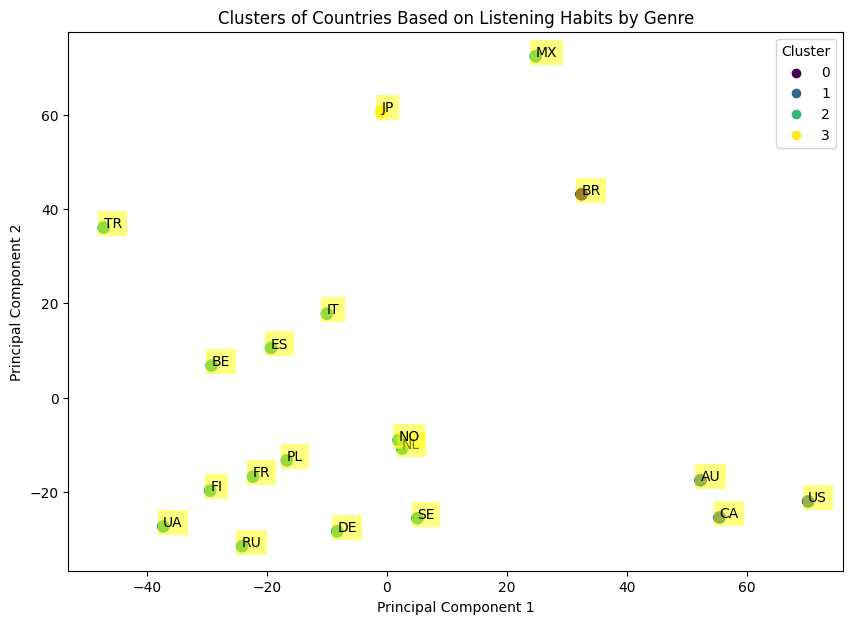

In [32]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Aggregate Listening Events by Genre for each Country
genre_distribution = df_active_countries_tags.groupby(['user_country', 'genre']).size().unstack(fill_value=0)

# Step 2: Normalize the data by the total number of listening events per country
genre_proportions = genre_distribution.div(genre_distribution.sum(axis=1), axis=0)

# Optional: Standardize the data for clustering
scaler = StandardScaler()
genre_proportions_scaled = scaler.fit_transform(genre_proportions)


# Remove rows with NaN values
genre_proportions_scaled = genre_proportions_scaled[~np.isnan(genre_proportions_scaled).any(axis=1)]

# Apply K-Means Clustering
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(genre_proportions_scaled)

# Add cluster labels to the DataFrame
genre_proportions = genre_proportions.dropna()
genre_proportions['Cluster'] = clusters



# Step 3: Apply K-Means Clustering
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(genre_proportions_scaled)

# Add cluster labels to the DataFrame
genre_proportions['Cluster'] = clusters


# Step 4: PCA for 2D Visualization
pca = PCA(n_components=2)
pca_components = pca.fit_transform(genre_proportions_scaled)

# Create a DataFrame with the PCA components and cluster labels
pca_df = pd.DataFrame(data=pca_components, columns=['PC1', 'PC2'])
pca_df['Cluster'] = clusters
pca_df['Country'] = genre_proportions.index

# Step 5: Plot the clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='viridis', s=100)

# Annotate the points with country labels
for i in range(pca_df.shape[0]):
    plt.text(x=pca_df.PC1[i], y=pca_df.PC2[i], s=pca_df.Country[i], 
             fontdict=dict(color='black',size=10),
             bbox=dict(facecolor='yellow', alpha=0.5, edgecolor='none'))

plt.title('Clusters of Countries Based on Listening Habits by Genre')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()



### Dashboard

In [33]:
music_consumption_description = """
## Music Consumption Patterns

This section provides a detailed analysis of music consumption patterns among users from various countries. The interactive plot displays the proportion of unique listening events categorized by the user's country of origin, their engagement with domestic music, music from selected artist countries, and music from other countries.

**Plot Explanation:**
- **User Country:** The country of the user whose music consumption pattern is being analyzed.
- **Artist Countries:** The countries of the artists whose music is consumed by the users. The plot categorizes music into three groups:
    - **Target Countries:** Music from the selected artist countries.
    - **Domestic:** Music from the user's own country.
    - **Other:** Music from all other countries not included in the above categories.
- **Proportions and Raw Numbers:** The plot can display either raw numbers of unique listening events or normalized percentages, providing a comparative view of how much users listen to music from different regions.

**Optimizations Implemented:**
- **Combined Data Filtering:** Gender, age group, and genre filters are now applied simultaneously in a single step, reducing the need for multiple passes over the data and speeding up the filtering process.
- **Vectorized Operations for Counting:** Unique listening events are counted using vectorized operations in Pandas, significantly improving performance over iterative methods, especially with large datasets.
- **Streamlined Sorting and Normalization:** Sorting of data and normalization to percentages have been optimized using built-in operations, reducing computational overhead and improving plot responsiveness.

These optimizations collectively ensure that the plot renders more quickly, even when working with large datasets or applying complex filters.
"""

music_export_matrix_description = """
## Music Export Matrix

This section visualizes the export patterns of music from various artist countries and how they are consumed by users across different countries. The interactive plot provides a matrix that represents the proportion of music consumption where rows correspond to the artist's country and columns correspond to the user's country.

**Plot Explanation:**
- **Artist Country:** The country where the music artist originates.
- **User Country:** The country of the user consuming the music.
- **Consumption Matrix:** The matrix shows the percentage of total music consumption from each artist country by users in different countries. The last row (Avg) shows the average consumption of music from various artist countries by users in each country.
- **Heatmap Visualization:** The plot uses color intensity to represent the percentage of music consumption, offering a clear, visual comparison across countries.

**Optimizations Implemented:**
- **Efficient Data Handling:** Filters for gender, age group, over genre, and genre are applied simultaneously using vectorized operations, reducing computation time and enhancing the responsiveness of the plot.
- **Optimized Calculation of Consumption Shares:** The matrix is built using efficient group-by operations and normalized to percentages directly during the aggregation process, avoiding the need for multiple passes through the data.
- **Streamlined Plot Rendering:** The heatmap is rendered with optimized matplotlib settings to ensure fast display even with large datasets, while providing detailed annotations to enhance interpretability.

These optimizations ensure that the Music Export Matrix is both performant and easy to interpret, even with complex filters and large datasets.
"""

age_distribution_description = """
## Age Distribution of Last.fm Users

This section provides an analysis of the age distribution among Last.fm users. The plot allows you to explore how different age groups are represented within the user base, and how this distribution changes across different countries and datasets.

**Plot Explanation:**
- **All Users:** The histogram shows the general age distribution of all users.
- **Male and Female Users:** The line plots overlay the age distribution of male and female users, helping to identify gender-specific trends.
- **Dataset and Country Filters:** Use the filters to switch between different datasets and countries, allowing for a more focused analysis of the age distribution.

**Optimizations Implemented:**
- **Combined Data Filtering:** Data is filtered for the selected country and dataset simultaneously, reducing the number of operations and improving efficiency.
- **Precomputed Bins:** Histogram bins are precomputed based on the maximum age across all datasets, which minimizes recalculation and enhances performance.
- **Streamlined Plotting:** The plotting process has been optimized with Seaborn's `histplot` and Matplotlib's layout adjustments, ensuring clear and responsive visualizations.

These optimizations ensure that the plot is both informative and performant, even when working with large datasets.
"""

country_user_chart_description = """
## Number of Users by Country

This section provides an analysis of the number of users by country. The plot allows you to explore the distribution of Last.fm users across various countries and how this distribution changes when focusing on active countries.

**Plot Explanation:**
- **Country:** The x-axis shows the country of the users.
- **Number of Users:** The y-axis represents either the number of users or the percentage, depending on the selected filters.
- **Active Countries:** The chart highlights active countries in green, with other countries grouped under "Other."

**Optimizations Implemented:**
- **Combined Data Filtering:** Data is filtered for gender, age group, and country simultaneously to optimize processing time.
- **Efficient Grouping:** User counts are computed using Pandas' group-by and nunique operations, ensuring quick aggregation.
- **Optimized Plot Rendering:** The chart is rendered using Matplotlib, with adjustments to bar colors and layout for clear visualization.

These optimizations ensure that the chart is both responsive and informative, even when dealing with large datasets.
"""

genre_chart_description = """
## Top 20 Genres

This section provides an analysis of the top 20 genres or over genres among Last.fm users. The plot allows you to explore how different genres are represented within the user base and how this distribution changes based on selected countries, gender, and age group.

**Plot Explanation:**
- **Genre or Over Genre:** The x-axis shows the selected genre type (either genre or over genre).
- **Listening Events:** The y-axis represents either the number of listening events or the percentage, depending on the selected filters.
- **Top 20 Genres:** The chart highlights the top 20 genres or over genres based on the selected filters, with all other genres grouped under "Other."

**Optimizations Implemented:**
- **Combined Data Filtering:** Data is filtered for selected countries, gender, and age group simultaneously to optimize processing time.
- **Efficient Grouping:** Genre counts are computed using Pandas' value_counts and efficient concatenation methods, ensuring quick aggregation.
- **Optimized Plot Rendering:** The chart is rendered using Matplotlib with adjustments to bar colors and layout for clear visualization, especially highlighting the overall top 5 genres or over genres.

These optimizations ensure that the chart is both responsive and informative, even when dealing with large datasets.
"""

artist_chart_description = """
## Top 20 Artists

This section provides an analysis of the top 20 artists among Last.fm users. The plot allows you to explore how different artists are represented within the user base and how this distribution changes based on selected countries, gender, and age group.

**Plot Explanation:**
- **Artist:** The x-axis shows the top 20 artists based on the selected filters.
- **Listening Events:** The y-axis represents either the number of listening events or the percentage, depending on the selected filters.
- **Top 5 Artists Highlighted:** The chart highlights the overall top 5 artists globally in green, making it easy to compare with other artists.

**Optimizations Implemented:**
- **Combined Data Filtering:** Data is filtered for selected countries, gender, and age group simultaneously to optimize processing time.
- **Efficient Grouping:** Artist counts are computed using Pandas' value_counts and efficient slicing methods, ensuring quick aggregation.
- **Optimized Plot Rendering:** The chart is rendered using Matplotlib with adjustments to bar colors and layout for clear visualization, especially highlighting the overall top 5 artists.

These optimizations ensure that the chart is both responsive and informative, even when dealing with large datasets.
"""

# Default description if none is provided
default_description = "## No Description Text Yet"


/var/folders/w6/ltv1n1td007c654n30qyrkkm0000gn/T/ipykernel_43744/755783416.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, 'artist_country'] = data['artist_country'].cat.set_categories(categories)
/var/folders/w6/ltv1n1td007c654n30qyrkkm0000gn/T/ipykernel_43744/755783416.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.loc[:, 'artist_country'] = data['artist_country'].cat.set_categories(categories)
/var/folders/w6/ltv1n1td007c654n30qyrkkm0000gn/T/ipykernel_43744/755783416.py:49: SettingWithCopyWarn

Launching server at http://localhost:62237


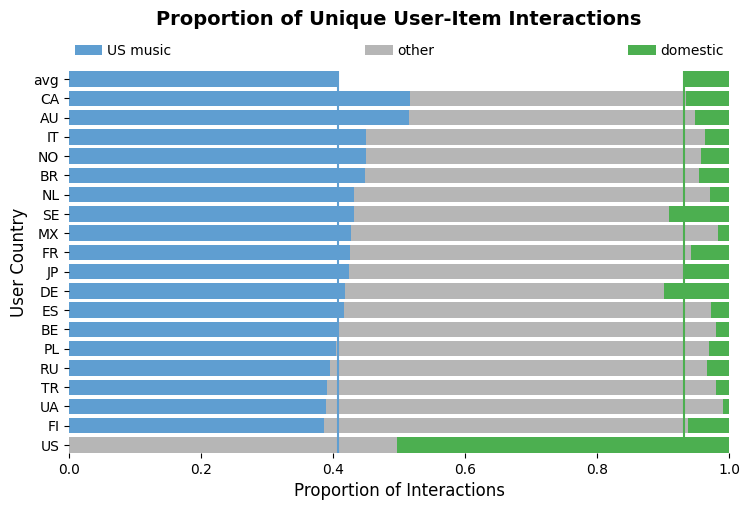

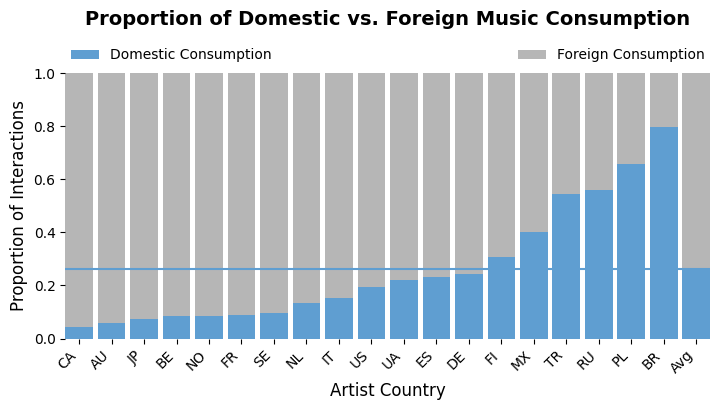

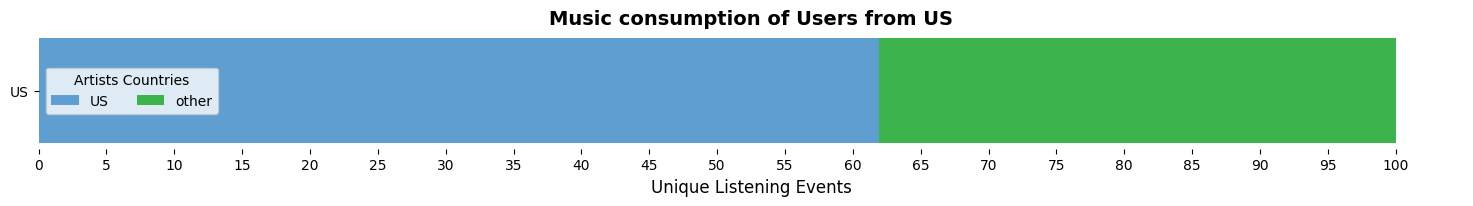

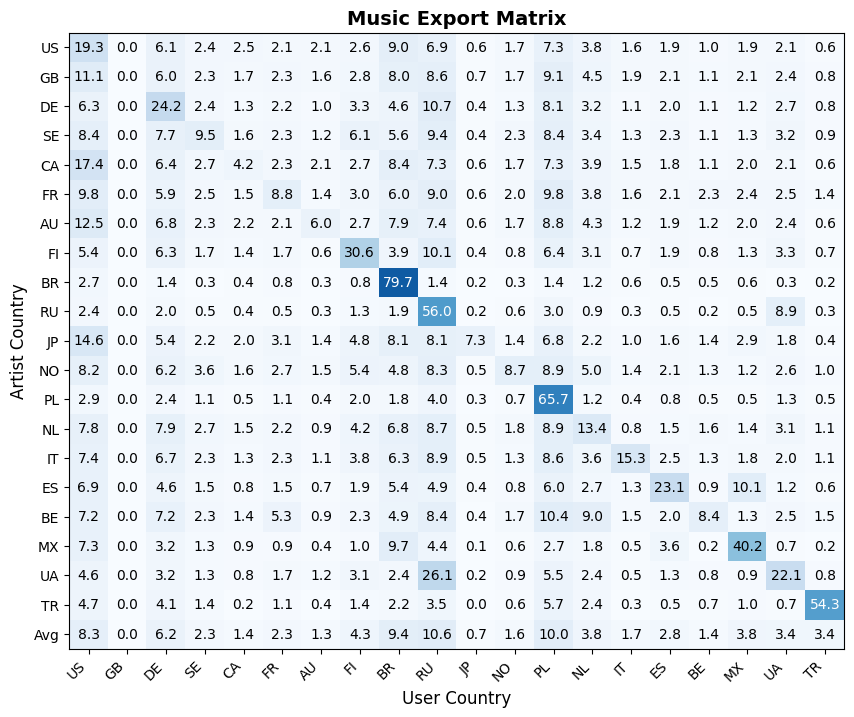

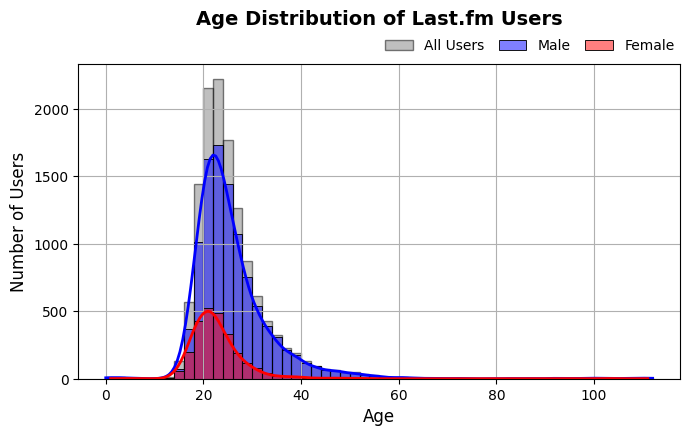

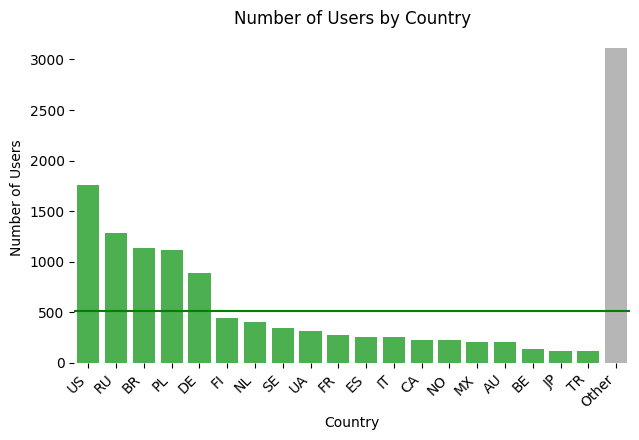

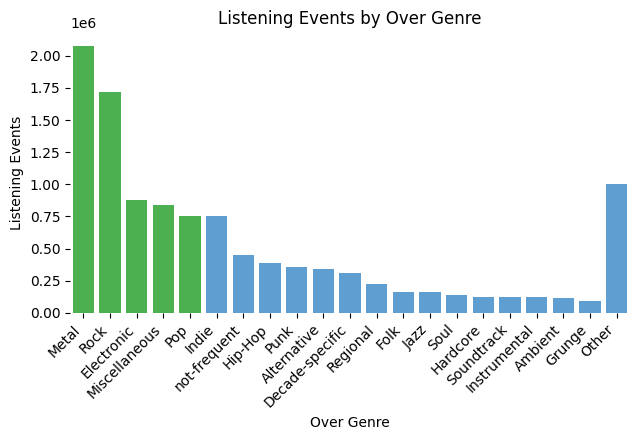

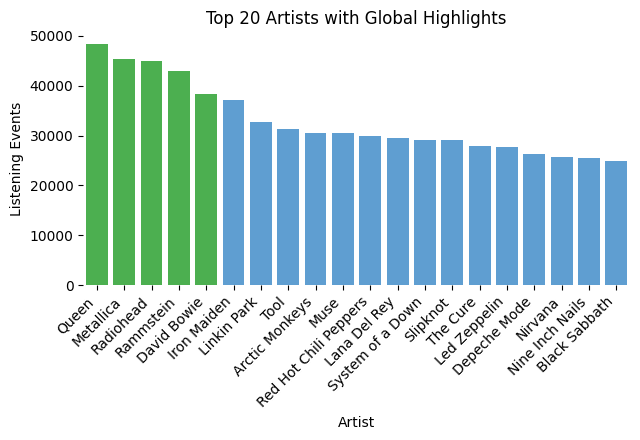

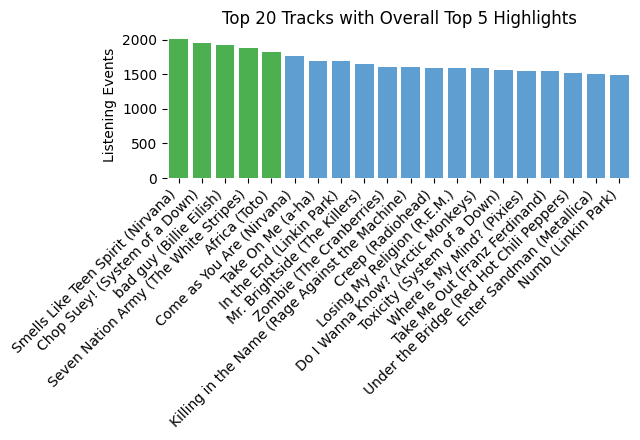

In [34]:
# Function to create plot sections
def create_plot_section(plot_title, plot_widget, description_text=None, plot_below_text=False):
    # Use default text if none is provided
    description_text = description_text or default_description
    
    if plot_below_text:
        markdown_text = pn.pane.Markdown(description_text)
    else: 
        markdown_text = pn.pane.Markdown(description_text, width=750)
    
    if plot_below_text:
        # Plot below text (for music consumption)
        return pn.Column(markdown_text, pn.Spacer(height=10), plot_widget, sizing_mode='stretch_width')
    else:
        # Plot beside text (default for all others)
        return pn.Row(markdown_text, plot_widget, sizing_mode='stretch_both')


# Create the plot sections
listening_activity_section = create_plot_section(
    plot_title="Listening Activity by Country",
    plot_widget=pn.Column(la_filter_section, pn.Spacer(height=10), listening_activity_widget, sizing_mode='stretch_width'),
    description_text=None  # Use default text
)

cd_section = create_plot_section(
    plot_title="Listening Activity by Country",
    plot_widget=pn.Column(cd_select_viz, pn.Spacer(height=10), cd_widget, sizing_mode='stretch_width'),
    description_text=None  # Use default text
)

music_consumption_section = create_plot_section(
    plot_title="Music Consumption Patterns",
    plot_widget=pn.Column(mc_select_viz, pn.Spacer(height=10), music_consumption_widget, sizing_mode='stretch_width'),
    description_text=music_consumption_description,
    plot_below_text=True  # Plot below the text, full-width
)

music_export_matrix_section = create_plot_section(
    plot_title="Music Export Matrix",
    plot_widget=pn.Column(mem_filter_section, pn.Spacer(height=10), music_export_matrix_widget, sizing_mode='stretch_width'),
    description_text=music_export_matrix_description
)

age_distribution_section = create_plot_section(
    plot_title="Age Distribution of Last.fm Users",
    plot_widget=pn.Column(age_distribution_filter_section, pn.Spacer(height=10), age_distribution_widget, sizing_mode='stretch_width'),
    description_text=age_distribution_description
)

country_user_chart_section = create_plot_section(
    plot_title="Number of Users by Country",
    plot_widget=pn.Column(country_user_filter_section, pn.Spacer(height=10), country_user_chart, sizing_mode='stretch_width'),
    description_text=country_user_chart_description
)

genre_chart_section = create_plot_section(
    plot_title="Top 20 Genres",
    plot_widget=pn.Column(genre_filter_section, pn.Spacer(height=10), genre_chart, sizing_mode='stretch_width'),
    description_text=genre_chart_description
)

artist_chart_section = create_plot_section(
    plot_title="Top 20 Artists",
    plot_widget=pn.Column(artist_filter_section, pn.Spacer(height=10), artist_chart, sizing_mode='stretch_width'),
    description_text=artist_chart_description
)

top_tracks_section = create_plot_section(
    plot_title="Top 20 Tracks",
    plot_widget=pn.Column(top_tracks_filter_section, pn.Spacer(height=10), top_tracks_widget, sizing_mode='stretch_width'),
    description_text=None  # Use default text
)



# Integrate into the main layout
main_layout = pn.Column(
    listening_activity_section,
    pn.Spacer(height=30),
    cd_section,
    pn.Spacer(height=30),
    music_export_matrix_section,
    pn.Spacer(height=30),
    music_consumption_section,
    pn.Spacer(height=30),
    age_distribution_section,
    pn.Spacer(height=30),
    country_user_chart_section,
    pn.Spacer(height=30),
    genre_chart_section,
    pn.Spacer(height=30),
    artist_chart_section,
    pn.Spacer(height=30),
    top_tracks_section,
    sizing_mode='stretch_both'
)

# Create the template
template = pn.template.MaterialTemplate(
    title='Music Consumption Dashboard',
    sidebar=[pn.pane.Markdown('# Filters')],
    main=[main_layout],
)

# Serve the dashboard
#template.show()
template.servable()
